#### Example using DEMReg and SDO/AIA data
Here using synthetic SDO/AIA data for a single "pixel" generated from a Gaussian DEM 

17-Aug-2020 IGH\
03-Feb-2021 IGH - Updated using new dn2dem_pos_selfnorm function


In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
# from dn2dem_pos import dn2dem_pos
from dn2dem_pos_selfnorm import dn2dem_pos_selfnorm

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [2]:
matplotlib.rcParams['font.size'] = 16

In [3]:
# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('aia_tresp_en.dat')

# Get rid of the b in the string name (byte vs utf stuff....)
for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")
print(trin['channels'])

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

['A94' 'A131' 'A171' 'A193' 'A211' 'A335']


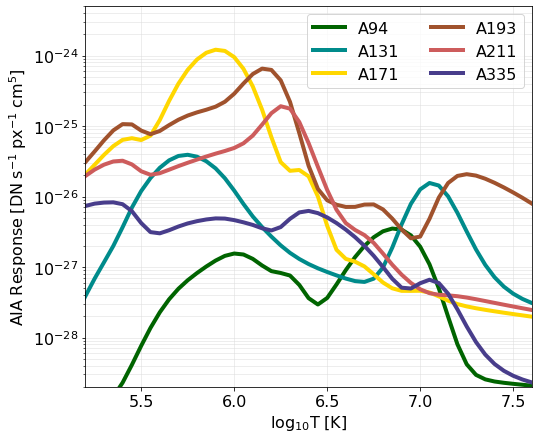

In [4]:
# Check the response look correct by plotting them

# Setup some AIA colours
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue']

# Do the plot
fig = plt.figure(figsize=(8, 7))
for i in np.arange(6):
    plt.semilogy(tresp_logt,trmatrix[:,i],label=trin['channels'][i],color=clrs[i],lw=4)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{AIA\;Response\;[DN\;s^{-1}\;px^{-1}\;cm^5]}$')
plt.ylim([2e-29,5e-24])
plt.xlim([5.2,7.6])
plt.legend(ncol=2,prop={'size': 16})
plt.rcParams.update({'font.size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
plt.show()


In [5]:
# For some DEM model (i.e. a Gaussian) produce the synthetic DN/s/px for each AIA channel
d1=4e22
m1=6.5
s1=0.15
root2pi=(2.*math.pi)**0.5
dem_mod=(d1/(root2pi*s1))*np.exp(-(tresp_logt-m1)**2/(2*s1**2))

# # Check what the DEM model looks like
# fig = plt.figure(figsize=(8, 4.5))
# plt.plot(tresp_logt,dem_mod)
# plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
# plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
# plt.ylim([2e20,4e23])
# plt.xlim([5.7,7.2])
# plt.rcParams.update({'font.size': 16})
# plt.yscale('log')
# plt.show()

# Now work out the DN/s/px
# For AIA responses all are dlogt=0.05
tresp_dlogt=np.full(nt,0.05)
tc_full=np.zeros([nt,nf])
for i in range(0,nf):
    tc_full[:,i]=dem_mod*trmatrix[:,i]*10**tresp_logt*np.log(10**tresp_dlogt)

dn_in=np.sum(tc_full,0)
print('dn_in: ',dn_in)

# And the associated uncertainty (no systematics)
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
# assume all obs were 2.9s long
dn0=dn_in*2.9
shotnoise=(dn2ph*dn0)**0.5/dn2ph/2.9
# error in DN/s/px
edn_in=(rdnse**2+shotnoise**2)**0.5 
print('edn_in: ',edn_in)

dn_in:  [  326.11015434   313.31711078  2663.51032758 11361.19773432
  8700.35614133  1208.36625462]
edn_in:  [14.94543538 12.67184957 32.12696435 61.39593311 51.38885685 15.53907416]


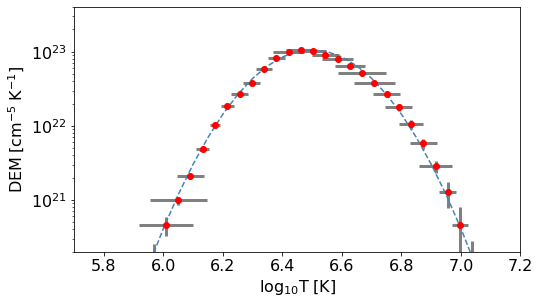

In [6]:
#  What temperature binning do we want for the output DEM?
#  These are the bin edges
temps=np.logspace(5.7,7.1,num=35)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

# Work out the DEM
dem,edem,elogt,chisq,dn_reg=dn2dem_pos_selfnorm(dn_in,edn_in,trmatrix,tresp_logt,temps)

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem,xerr=elogt,yerr=edem,fmt='or',ecolor='gray', elinewidth=3, capsize=0)
plt.plot(tresp_logt,dem_mod,'--',color='steelblue')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e20,4e23])
plt.xlim([5.7,7.2])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.show()


In [7]:
# # # Previous way of manually running twice
# # # First time no weighting/normalisation, 2nd time using result from first runWork out the DEM
# # ~~~~~~~~
# # Now that we have a rough DEM solution could run in again using this to weight the DEM solution
# # Original idl version of DEM code did this by default but mapping removed it as slower overall
# dem,edem,elogt,chisq,dn_reg=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps)
# dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,dem_norm0=dem/np.max(dem))

# #  Plot it all
# fig = plt.figure(figsize=(8, 4.5))
# plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',ecolor='gray', elinewidth=3, capsize=0)
# plt.plot(tresp_logt,dem_mod,'--',color='steelblue')
# plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
# plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
# plt.ylim([2e20,4e23])
# plt.xlim([5.7,7.2])
# plt.rcParams.update({'font.size': 16})
# plt.yscale('log')
# plt.title('')
# plt.savefig('demregpy_aiasyn.png',bbox_inches='tight')
# plt.show()

In [8]:
# # Now lets try making a 2D array (really 3D as x,y,f) from the synthetic pixel above to test speed of the code:
# # If lot's of data will run in parallel instead of serial
# nx=100
# ny=100
# dn_in2d=np.zeros([nx,ny,nf])
# edn_in2d=np.zeros([nx,ny,nf])
# for y in np.arange(ny):
#     for x in np.arange(nx):
#         dn_in2d[x,y,:]=dn_in
#         edn_in2d[x,y,:]=edn_in 
# dem2d,edem2d,elogt2d,chisq2d,dn_reg2d=dn2dem_pos(dn_in2d,edn_in2d,trmatrix,tresp_logt,temps)